# Exoplanet detection using AI

This notebook will explore datasets related to exoplanet detection, specifically the Kepler and TESS missions. We will use Python libraries such as Pandas, NumPy, Matplotlib, and Scikit-learn to analyze the data and build a machine learning model to classify potential exoplanets.

Mas especificamente este notebook es el "hijo" de un notebook anterior que se llama "model.ipynb" y que contiene el modelo inicial donde se hacen un monton de proceso, pruebas y concluciones pero que fueron todas haciendo la postura de no tomar los false positive, sino que se trataba de un modelo binario (planet, no planet). En este notebook se va a tratar de hacer un modelo que tome en cuenta los false positive y que pueda distinguir entre planetas, false positive y no planetas o la ampliacion del modelo de model.ipnynb a un modelo que pueda reconocer de forma inferida los false positive siendo que pueda reentrenarse con las mismas categorias de salida (planet o no planet) pero esta vez tomando las false positive como no planet y se muestren cierta cantidad den el train y otra en el test pudiendo ser que se muestren el 50% en el train y el restante en el test y ver si de esa forma se encuentra la fina distincion que suponemos se puede lograr entre los false positive y los positive. Creemos que va a ser dificil realizar la distincion ya que haciendo la prueba de este modelo viejo probandolo con todos los datos nos dio que la mayoria de los 1 eran positives pero ademas estaban sumados la mayoria de los false positive, y los 0 eran no planetas, pero no se podia distinguir entre false positive y positive.

La idea es que este modelo pueda ser reentrenado con los datos de salida de los modelos anteriores y que pueda ir aprendiendo a distinguir entre false positive y positive, pero que en un principio se entrene con los datos originales pero tomando los false positive como no planetas.

*Exploring the data*

In [1]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
#path = r"C:\Users\matir\OneDrive\Documentos\NASA\Exoplanet detection using AI\data\cumulative_2025.10.04_05.21.55.csv"
path = "data/cumulative_2025.10.04_05.21.55.csv"
df = pd.read_csv(
    path,
    comment='#',      # ignore metadata lines starting with '#'
    engine='python',  # more forgiving parser
)
df.head()


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [4]:
df.info()
df.describe()
df.isnull().sum().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2747 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

koi_teq_err1         9564
koi_teq_err2         9564
kepler_name          6817
koi_score            1510
koi_steff_err2        483
koi_srad_err1         468
koi_steff_err1        468
koi_slogg_err2        468
koi_slogg_err1        468
koi_srad_err2         468
koi_time0bk_err1      454
koi_period_err1       454
koi_period_err2       454
koi_time0bk_err2      454
koi_impact_err1       454
koi_depth_err1        454
koi_depth_err2        454
koi_duration_err1     454
koi_duration_err2     454
koi_impact_err2       454
dtype: int64

In [5]:
df['koi_disposition'].value_counts()


koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

In [6]:
# Eliminar columnas irrelevantes y/o vacias
columnas_despues = ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']
cols_drop = ['rowid','kepid','kepoi_name','kepler_name','koi_pdisposition','koi_score','koi_teq_err1','koi_teq_err2','koi_tce_delivname','koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']
df = df.drop(columns=[c for c in cols_drop if c in df.columns])

df.columns


Index(['koi_disposition', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec',
       'koi_kepmag'],
      dtype='object')

Text(0.5, 1.0, 'Distribución de Confirmed vs Candidate')

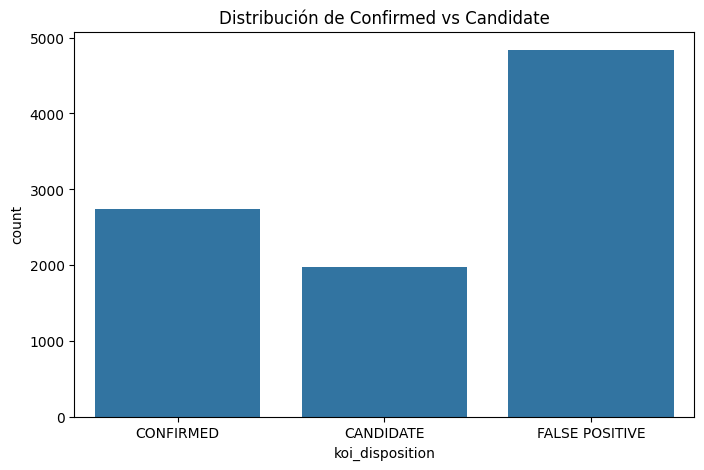

In [7]:
# Visualización de la distribución de las clases
plt.figure(figsize=(8,5))
sns.countplot(x='koi_disposition', data=df)
plt.title('Distribución de Confirmed vs Candidate')


In [8]:
# Reemplazá NaN con la media
from sklearn.discriminant_analysis import StandardScaler

df = df.fillna(df.median(numeric_only=True))

# Split de features y target
X = df.drop(columns=['koi_disposition',])
y = df['koi_disposition']

print(df.shape, X.shape, y.shape)
print(X.columns)

non_numeric_cols = X.select_dtypes(exclude=np.number).columns.tolist()
print(non_numeric_cols)  # para ver algunas

# Si solo son IDs o etiquetas drop
X = X.drop(columns=non_numeric_cols)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

(9564, 37) (9564, 36) (9564,)
Index(['koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk',
       'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1',
       'koi_impact_err2', 'koi_duration', 'koi_duration_err1',
       'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2',
       'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg',
       'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1',
       'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')
[]


In [21]:

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [55]:
# separar en train, test y validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)


(6694, 36) (1435, 36) (1435, 36)


In [56]:
print("Distribución de y_train:")
print(pd.Series(y_train).value_counts())
print("Distribución de y_test:")
print(pd.Series(y_test).value_counts())

Distribución de y_train:
koi_disposition
FALSE POSITIVE    3387
CONFIRMED         1922
CANDIDATE         1385
Name: count, dtype: int64
Distribución de y_test:
koi_disposition
FALSE POSITIVE    726
CONFIRMED         412
CANDIDATE         297
Name: count, dtype: int64


In [ ]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

def add_false_positives_half(
    X_train, y_train, X_test, y_test,
    X_fp,                      # numpy array de FP (mismas columnas/features)
    groups_fp=None,            # opcional: array con kepid u otro ID por fila de X_fp
    random_state=42
):
    n_fp = X_fp.shape[0]
    y_fp = np.zeros(n_fp, dtype=int)     # todos los FP son clase 0

    # Split 50/50 de FP (ideal: por grupos/estrellas)
    if groups_fp is not None:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=random_state)
        idx = np.arange(n_fp)
        fp_train_rel, fp_test_rel = next(gss.split(idx, groups=groups_fp))
        fp_train_idx, fp_test_idx = idx[fp_train_rel], idx[fp_test_rel]
    else:
        rng = np.random.default_rng(random_state)
        perm = rng.permutation(n_fp)
        half = n_fp // 2
        fp_train_idx, fp_test_idx = perm[:half], perm[half:]

    X_fp_train, y_fp_train = X_fp[fp_train_idx], y_fp[fp_train_idx]
    X_fp_test,  y_fp_test  = X_fp[fp_test_idx],  y_fp[fp_test_idx]

    # Concatenar a tus splits existentes
    X_train_new = np.vstack([X_train, X_fp_train])
    y_train_new = np.concatenate([y_train, y_fp_train])
    X_test_new  = np.vstack([X_test,  X_fp_test])
    y_test_new  = np.concatenate([y_test,  y_fp_test])

    return X_train_new, y_train_new, X_test_new, y_test_new, fp_train_idx, fp_test_idx


In [58]:
X_fp = df[df['koi_disposition'] == 'FALSE POSITIVE'].drop(columns=['koi_disposition'] + non_numeric_cols).values
print("FP shape:", X_fp.shape)

FP shape: (4839, 36)


In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6694, 36), (6694,), (1435, 36), (1435,))

In [60]:
X_train, y_train, X_test, y_test, fp_train_idx, fp_test_idx = add_false_positives_half(
    X_train, y_train, X_test, y_test, X_fp
)

In [63]:
print("Distribución de y_train:")
print(pd.Series(y_train).value_counts())
print("Distribución de y_test:")
print(pd.Series(y_test).value_counts())

Distribución de y_train:
0    7191
1    1922
Name: count, dtype: int64
Distribución de y_test:
0                 2420
FALSE POSITIVE     726
CONFIRMED          412
CANDIDATE          297
Name: count, dtype: int64


In [64]:
# transform all Positive or False Positive or Candidate labels to 1 or 0 (y_train and y_test dont have .map method)
# if y_train == 'CONFIRMED' or y_train == 1 =1
# if y_train == 'CANDIDATE' =0 or y_train == 0 =0
# if y_train == 'FALSE POSITIVE' =0 or y_train == 0 =0
for index, i in enumerate(y_train):
    if i == 'CONFIRMED' or i == 1:
        y_train[index] = 1
        print("ffff", y_train[index])
    elif i == 'CANDIDATE' or i == 0:
        y_train[index] = 0
    elif i == 'FALSE POSITIVE' or i == 0:
        y_train[index] = 0
#y_train[3]=1

for index, i in enumerate(y_test):
    if i == 'CONFIRMED' or i == 1:
        y_test[index] = 1
        print("ffff", y_test[index])
    elif i == 'CANDIDATE' or i == 0:
        y_test[index] = 0
    elif i == 'FALSE POSITIVE' or i == 0:
        y_test[index] = 0
#y_train[3]=1

#chequear si se cambiaron bien las etiquetas (fijarse cuantos 0 y 1 hay)()
print("Distribución de y_train:")
print(pd.Series(y_train).value_counts())
print("Distribución de y_test:")
print(pd.Series(y_test).value_counts())

y_train


ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1
ffff 1

array([0, 0, 0, ..., 0, 0, 0], shape=(9113,), dtype=object)

In [65]:
print("Distribución de y_train:")
print(pd.Series(y_train).value_counts())
print("Distribución de y_test:")
print(pd.Series(y_test).value_counts())

Distribución de y_train:
0    7191
1    1922
Name: count, dtype: int64
Distribución de y_test:
0    3443
1     412
Name: count, dtype: int64


In [66]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9113, 36), (9113,), (3855, 36), (3855,))

In [67]:
def build_models():
    rf = RandomForestClassifier(
        n_estimators=1600, criterion='entropy', random_state=42, n_jobs=-1
    )
    et = ExtraTreesClassifier(
        n_estimators=200, criterion='entropy', random_state=42, n_jobs=-1
    )
    adb = AdaBoostClassifier(
        n_estimators=974, learning_rate=0.1, random_state=42
    )
    gb = GradientBoostingClassifier(
        n_estimators=1600, learning_rate=0.1, random_state=42
    )
    meta = LogisticRegression(max_iter=1000, random_state=42)
    stack = StackingClassifier(
        estimators=[('rf', rf), ('gb', gb)],
        final_estimator=meta,
        cv=5,
        n_jobs=-1,
        passthrough=False
    )
    return {
        'RandomForest': rf,
        'ExtraTrees': et,
        'AdaBoost': adb,
        'Stacking': stack
    }

modelos = build_models()

In [68]:
def stratified_metrics_at_threshold(y_true, y_proba, subgroup, thr):
    y_pred = (y_proba >= thr).astype(int)
    # Máscara por subgrupo en test
    m_conf = subgroup == 'CONFIRMED'
    m_cand = subgroup == 'CANDIDATE'
    m_fp   = subgroup == 'FALSE POSITIVE'
    
    # TPR (recall) en confirmados (true label=1)
    tpr_conf = ( (y_pred[m_conf] == 1).sum() / max(1, (y_true[m_conf] == 1).sum()) ) if m_conf.any() else np.nan
    
    # FPR en FP y en candidates (subgrupos con true label=0)
    # (predice 1 cuando la verdad es 0 dentro de cada subgrupo)
    def fpr(mask):
        if not mask.any(): 
            return np.nan
        tn_fp = (y_true[mask] == 0).sum()
        if tn_fp == 0: 
            return np.nan
        return ( (y_pred[mask] == 1).sum() / tn_fp )
    
    fpr_fp   = fpr(m_fp)
    fpr_cand = fpr(m_cand)
    
    return tpr_conf, fpr_fp, fpr_cand

def pick_operating_point(y_true, y_proba, subgroup, max_fpr_fp=0.10, grid=np.linspace(0.01, 0.99, 99)):
    # Selecciona el umbral con FPR_FP <= max_fpr_fp que maximiza TPR_confirmed.
    # Si ninguno cumple, elige el de menor FPR_FP; si empata, mayor TPR.
    best = {'thr': None, 'tpr_conf': -1, 'fpr_fp': 1e9, 'fpr_cand': None}
    candidates = []
    for thr in grid:
        tpr_conf, fpr_fp, fpr_cand = stratified_metrics_at_threshold(y_true, y_proba, subgroup, thr)
        candidates.append((thr, tpr_conf, fpr_fp, fpr_cand))
    
    # Primero, los que cumplen el tope de FPR_FP
    valid = [c for c in candidates if np.isfinite(c[2]) and c[2] <= max_fpr_fp]
    if valid:
        # Maximizá TPR_confirmed; tie-break: menor FPR_FP; luego umbral más alto
        valid.sort(key=lambda x: (-(x[1] if x[1] is not None else -1), x[2], -x[0]))
        thr, tpr_conf, fpr_fp, fpr_cand = valid[0]
    else:
        # Ninguno cumple → minimizá FPR_FP; tie-break: mayor TPR
        filt = [c for c in candidates if np.isfinite(c[2])]
        filt.sort(key=lambda x: (x[2], -(x[1] if x[1] is not None else -1), -x[0]))
        thr, tpr_conf, fpr_fp, fpr_cand = filt[0]
    
    return {
        'thr': thr,
        'TPR_confirmed': tpr_conf,
        'FPR_FP': fpr_fp,
        'FPR_candidates': fpr_cand
    }

In [71]:
print("X_train dtype:", getattr(X_train, "dtype", None))
print("X_test  dtype:", getattr(X_test,  "dtype", None))
print("y_train dtype:", getattr(y_train, "dtype", None), "unique:", np.unique(y_train))
print("y_test  dtype:", getattr(y_test,  "dtype", None), "unique:", np.unique(y_test))


X_train dtype: float64
X_test  dtype: float64
y_train dtype: object unique: [0 1]
y_test  dtype: object unique: [0 1]


In [72]:
print("Distribución de y_train:")
print(pd.Series(y_train).value_counts())
print("Distribución de y_test:")
print(pd.Series(y_test).value_counts())

Distribución de y_train:
0    7191
1    1922
Name: count, dtype: int64
Distribución de y_test:
0    3443
1     412
Name: count, dtype: int64


In [74]:
#chequear si hay nans en y_train o y_test
print("y_train tiene NaNs?", pd.isnull(y_train).any())
print("y_test tiene NaNs?", pd.isnull(y_test).any())

y_train tiene NaNs? False
y_test tiene NaNs? False


In [77]:
from sklearn.utils.multiclass import type_of_target
import numpy as np, pandas as pd

def diag_y(y, name):
    a = np.asarray(y)
    print(f"{name}: type={type(y)}, shape={a.shape}, np.dtype={a.dtype}, sk_type={type_of_target(a)}")

diag_y(y_train, "y_train")
diag_y(y_test,  "y_test")


y_train: type=<class 'numpy.ndarray'>, shape=(9113,), np.dtype=object, sk_type=unknown
y_test: type=<class 'numpy.ndarray'>, shape=(3855,), np.dtype=object, sk_type=unknown


In [78]:
# Forzar 1D + int64 "duro" en y
y_train = pd.Series(y_train).astype("int64").to_numpy().ravel()
y_test  = pd.Series(y_test ).astype("int64").to_numpy().ravel()

# (Opcional pero recomendable) asegurar X como float NumPy 2D
X_train = np.asarray(X_train, dtype=float)
X_test  = np.asarray(X_test,  dtype=float)

# Chequeo post-fix
from sklearn.utils.multiclass import type_of_target
print("y_train sk_type:", type_of_target(y_train), "  uniques:", np.unique(y_train))
print("y_test  sk_type:", type_of_target(y_test),  "  uniques:", np.unique(y_test))


y_train sk_type: binary   uniques: [0 1]
y_test  sk_type: binary   uniques: [0 1]


In [79]:
# -*- coding: utf-8 -*-
import json, os
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    precision_recall_curve, classification_report
)
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
)
from sklearn.linear_model import LogisticRegression

# =========================
# Config
# =========================
RANDOM_STATE = 42
MODELS_DIR = Path("models/fps")
MODELS_DIR.mkdir(exist_ok=True, parents=True)

# =========================
# Helpers
# =========================

def build_subgroup_table(y_true, y_pred, subgroup):
    """Devuelve una tabla con TP, TN, FP, FN y tasas por subgrupo del test."""
    rows = []
    subcats = pd.Series(subgroup).astype(str).unique().tolist()
    for sg in subcats:
        m = (subgroup == sg)
        yt = y_true[m]
        yp = y_pred[m]
        n = int(m.sum())
        if n == 0:
            continue
        P = int((yt == 1).sum())
        N = int((yt == 0).sum())
        TP = int(((yt == 1) & (yp == 1)).sum())
        FN = int(((yt == 1) & (yp == 0)).sum())
        FP = int(((yt == 0) & (yp == 1)).sum())
        TN = int(((yt == 0) & (yp == 0)).sum())
        tpr = TP / (TP + FN) if (TP + FN) > 0 else np.nan      # recall (si hay positivos)
        fpr = FP / (FP + TN) if (FP + TN) > 0 else np.nan      # tasa de falsos positivos (si hay negativos)
        tnr = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        fnr = FN / (FN + TP) if (FN + TP) > 0 else np.nan
        acc_sg = (TP + TN) / n if n > 0 else np.nan
        ppr = (TP + FP) / n  # predicted positive rate
        rows.append({
            "subgroup": sg,
            "N": n,
            "P(true=1)": P,
            "N(true=0)": N,
            "TP": TP, "TN": TN, "FP": FP, "FN": FN,
            "Accuracy_sg": round(float(acc_sg), 4),
            "TPR_recall": round(float(tpr), 4) if np.isfinite(tpr) else None,
            "FPR": round(float(fpr), 4) if np.isfinite(fpr) else None,
            "TNR": round(float(tnr), 4) if np.isfinite(tnr) else None,
            "FNR": round(float(fnr), 4) if np.isfinite(fnr) else None,
            "PredPosRate": round(float(ppr), 4),
        })
    return pd.DataFrame(rows)

def safe_proba(clf, X, pos_label=1):
    import numpy as np
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X)
        classes = getattr(clf, "classes_", None)
        if proba.ndim == 2 and classes is not None:
            if proba.shape[1] == 2:
                j = int(np.where(classes == pos_label)[0][0])
                return proba[:, j]
            if proba.shape[1] == 1:
                learned = classes[0] if classes is not None and len(classes)==1 else None
                return np.full(X.shape[0], 1.0 if learned == pos_label else 0.0, dtype=float)
        return proba.ravel().astype(float)
    if hasattr(clf, "decision_function"):
        z = clf.decision_function(X)
        z = (z - z.min()) / (z.max() - z.min() + 1e-9)
        return z.astype(float)
    return clf.predict(X).astype(float)



def f1_from_pr(prec, rec):
    denom = (prec + rec)
    denom[denom == 0] = 1e-9
    return 2 * prec * rec / denom

def choose_threshold_max_f1(y_true, y_proba):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    f1 = f1_from_pr(prec[:-1], rec[:-1])  # descarta último punto (sin threshold)
    i = np.argmax(f1)
    return float(thr[i])

def stratified_metrics_at_thr(y_true, y_proba, subgroup, thr):
    y_pred = (y_proba >= thr).astype(int)
    # Masks
    m_conf = subgroup == 'CONFIRMED'
    m_cand = subgroup == 'CANDIDATE'
    m_fp   = subgroup == 'FALSE POSITIVE'
    # TPR en confirmados (clase 1)
    tpr_conf = np.nan
    if m_conf.any():
        denom = max(1, (y_true[m_conf] == 1).sum())
        tpr_conf = ( (y_pred[m_conf] == 1).sum() / denom )
    # FPR en FP y CAND (casos true=0 pred=1)
    def fpr(mask):
        if not mask.any(): return np.nan
        neg = (y_true[mask] == 0).sum()
        if neg == 0: return np.nan
        return ( (y_pred[mask] == 1).sum() / neg )
    return float(tpr_conf), float(fpr(m_fp)), float(fpr(m_cand))

def choose_threshold_with_fp_cap(y_true, y_proba, subgroup, max_fpr_fp=0.10):
    grid = np.linspace(0.01, 0.99, 99)
    candidates = []
    for thr in grid:
        tpr_c, fpr_fp, fpr_cand = stratified_metrics_at_thr(y_true, y_proba, subgroup, thr)
        candidates.append((thr, tpr_c, fpr_fp, fpr_cand))
    # primero los que cumplen el cap
    valid = [c for c in candidates if np.isfinite(c[2]) and c[2] <= max_fpr_fp]
    if valid:
        # max TPR_conf, tie-break: menor FPR_FP, luego thr más alto
        valid.sort(key=lambda x: (-(x[1] if np.isfinite(x[1]) else -1), x[2], -x[0]))
        return {
            'thr': float(valid[0][0]),
            'TPR_confirmed': float(valid[0][1]),
            'FPR_FP': float(valid[0][2]),
            'FPR_candidates': float(valid[0][3]),
        }
    # si ninguno cumple, minimizá FPR_FP; tie-break: mayor TPR_conf
    candidates = [c for c in candidates if np.isfinite(c[2])]
    candidates.sort(key=lambda x: (x[2], -(x[1] if np.isfinite(x[1]) else -1), -x[0]))
    best = candidates[0]
    return {
        'thr': float(best[0]),
        'TPR_confirmed': float(best[1]),
        'FPR_FP': float(best[2]),
        'FPR_candidates': float(best[3]),
    }

# =========================
# Construcción de modelos
# =========================
def build_models():
    rf = RandomForestClassifier(
        n_estimators=1600, criterion='entropy', random_state=RANDOM_STATE, n_jobs=-1
    )
    et = ExtraTreesClassifier(
        n_estimators=200, criterion='entropy', random_state=RANDOM_STATE, n_jobs=-1
    )
    adb = AdaBoostClassifier(
        n_estimators=974, learning_rate=0.1, random_state=RANDOM_STATE
    )
    gb = GradientBoostingClassifier(
        n_estimators=1600, learning_rate=0.1, random_state=RANDOM_STATE
    )
    meta = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    stack = StackingClassifier(
        estimators=[('rf', rf), ('gb', gb)],
        final_estimator=meta,
        cv=5,
        n_jobs=-1,
        passthrough=False
    )
    return {
        "RandomForest_fp": rf,
        "ExtraTrees_fp": et,
        "AdaBoost_fp": adb,
        "Stacking_fp": stack
    }

# =========================
# Entrenar, guardar, evaluar
# =========================
def train_save_eval_all(
    X_train, y_train, X_test, y_test,
    subgroup_test=None,    # np.array(['CONFIRMED','CANDIDATE','FALSE POSITIVE',...])
    max_fpr_fp=0.10
):
    models = build_models()
    rows_summary = []
    all_subgroups = []  # para juntar tablas de todos los modelos

    for name, clf in models.items():
        print(f"\n=== Entrenando {name} ===")
        clf.fit(X_train, y_train)
        # Dentro de train_save_eval_all(), justo después de clf.fit(X_train, y_train):
        unique, counts = np.unique(y_train, return_counts=True)
        print(f"y_train distrib: {dict(zip(unique.tolist(), counts.tolist()))}")

        classes = getattr(clf, "classes_", None)
        print(f"{name} classes_ aprendidas: {classes}")

        if classes is not None and len(classes) < 2:
            print(f"⚠️  Aviso: {name} se entrenó con UNA sola clase ({classes[0]}). "
                f"Revisá tu split: asegurá que y_train tenga 0s y 1s.")

        # Guardar modelo
        model_path = MODELS_DIR / f"{name}.pkl"
        joblib.dump(clf, model_path)
        print(f"Guardado: {model_path}")

        # Probabilidades
        y_proba = safe_proba(clf, X_test)

        # Métricas globales @0.5
        y_pred05 = (y_proba >= 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred05)
        prec = precision_score(y_test, y_pred05, zero_division=0)
        rec = recall_score(y_test, y_pred05, zero_division=0)
        f1 = f1_score(y_test, y_pred05, zero_division=0)
        cm = confusion_matrix(y_test, y_pred05)
        try:
            roc = roc_auc_score(y_test, y_proba)
        except:
            roc = np.nan
        ap = average_precision_score(y_test, y_proba)

        # Elegir umbral operativo
        meta_thr = {}
        if subgroup_test is not None:
            meta_thr = choose_threshold_with_fp_cap(y_test, y_proba, subgroup_test, max_fpr_fp=max_fpr_fp)
            thr = meta_thr['thr']
        else:
            thr = choose_threshold_max_f1(y_test, y_proba)
            meta_thr = {"thr": thr}

        # Métricas al umbral elegido
        y_pred_thr = (y_proba >= thr).astype(int)
        acc_thr = accuracy_score(y_test, y_pred_thr)
        prec_thr = precision_score(y_test, y_pred_thr, zero_division=0)
        rec_thr = recall_score(y_test, y_pred_thr, zero_division=0)
        f1_thr = f1_score(y_test, y_pred_thr, zero_division=0)
        cm_thr = confusion_matrix(y_test, y_pred_thr)

        # Report corto
        print(f"Umbral elegido: {thr:.3f} | PR-AUC={ap:.4f} | ROC-AUC={roc:.4f}")
        print(f"[0.5]     Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f}  CM={cm.tolist()}")
        print(f"[@thr]    Acc={acc_thr:.3f} Prec={prec_thr:.3f} Rec={rec_thr:.3f} F1={f1_thr:.3f} CM={cm_thr.tolist()}")
        if subgroup_test is not None:
            print(f"          TPR_confirmed={meta_thr['TPR_confirmed']:.3f}  FPR_FP={meta_thr['FPR_FP']:.3f}  FPR_candidates={meta_thr['FPR_candidates']:.3f}")

        # Guardar metadatos (umbral y métricas)
        meta_to_save = {
            "threshold": float(thr),
            "PR_AUC": float(ap),
            "ROC_AUC": float(roc) if roc==roc else None,
            "metrics@0.5": {
                "accuracy": float(acc), "precision": float(prec),
                "recall": float(rec), "f1": float(f1),
                "confusion_matrix": cm.tolist()
            },
            "metrics@thr": {
                "accuracy": float(acc_thr), "precision": float(prec_thr),
                "recall": float(rec_thr), "f1": float(f1_thr),
                "confusion_matrix": cm_thr.tolist()
            }
        }
        # añade TPR/FPR si existen
        for k in ("TPR_confirmed","FPR_FP","FPR_candidates"):
            if k in meta_thr:
                meta_to_save[k] = float(meta_thr[k])

        with open(MODELS_DIR / f"{name}_meta.json", "w", encoding="utf-8") as f:
            json.dump(meta_to_save, f, ensure_ascii=False, indent=2)

        # --- NUEVO: tabla estratificada por subgrupo @thr ---
        if subgroup_test is not None:
            df_sg = build_subgroup_table(y_test, y_pred_thr, subgroup_test)
            df_sg.insert(0, "model", name)
            all_subgroups.append(df_sg)
            # guardar CSV por modelo
            csv_path = MODELS_DIR / f"{name}_subgroup_eval.csv"
            df_sg.to_csv(csv_path, index=False)
            print(f"Tabla por subgrupo guardada en: {csv_path}")

        # Para tabla resumen
        row = {
            "model": name,
            "PR_AUC": round(float(ap), 4),
            "ROC_AUC": round(float(roc), 4) if roc==roc else None,
            "thr*": round(float(thr), 3),
            "Acc@0.5": round(float(acc), 4),
            "F1@0.5": round(float(f1), 4),
            "Acc@thr": round(float(acc_thr), 4),
            "F1@thr": round(float(f1_thr), 4),
        }
        if subgroup_test is not None:
            row.update({
                "TPR_confirmed@thr": round(float(meta_thr['TPR_confirmed']), 4),
                "FPR_FP@thr": round(float(meta_thr['FPR_FP']), 4),
                "FPR_cand@thr": round(float(meta_thr['FPR_candidates']), 4),
            })
        rows_summary.append(row)

    results = pd.DataFrame(rows_summary).sort_values(["F1@thr","PR_AUC"], ascending=False)
    results_by_subgroup = pd.concat(all_subgroups, ignore_index=True) if all_subgroups else pd.DataFrame()
    # También guardamos la tabla completa por subgrupo
    if not results_by_subgroup.empty:
        results_by_subgroup.to_csv(MODELS_DIR / "ALL_MODELS_subgroup_eval.csv", index=False)
    return results, results_by_subgroup

# =========================
# USO: reemplazá con tus arrays
# =========================
# X_train, y_train, X_test, y_test = ...  # ya los tenés
# subgroup_test = None  # o np.array([...]) con etiquetas 'CONFIRMED'/'CANDIDATE'/'FALSE POSITIVE'


results, results_by_subgroup = train_save_eval_all(
    X_train, y_train, X_test, y_test,
    subgroup_test=None,   # si no lo tenés, poné None y la tabla estratificada no se genera
    max_fpr_fp=0.10                # ajustá el tope de FPR sobre FP
)

print("\nResumen por modelo:\n", results.to_string(index=False))
if not results_by_subgroup.empty:
    print("\nMétricas por subgrupo (primeras filas):\n", results_by_subgroup.head().to_string(index=False))



=== Entrenando RandomForest_fp ===
y_train distrib: {0: 7191, 1: 1922}
RandomForest_fp classes_ aprendidas: [0 1]
Guardado: models\fps\RandomForest_fp.pkl
Umbral elegido: 0.383 | PR-AUC=0.9250 | ROC-AUC=0.9906
[0.5]     Acc=0.968 Prec=0.880 Rec=0.816 F1=0.846  CM=[[3397, 46], [76, 336]]
[@thr]    Acc=0.970 Prec=0.836 Rec=0.891 F1=0.863 CM=[[3371, 72], [45, 367]]

=== Entrenando ExtraTrees_fp ===
y_train distrib: {0: 7191, 1: 1922}
ExtraTrees_fp classes_ aprendidas: [0 1]
Guardado: models\fps\ExtraTrees_fp.pkl
Umbral elegido: 0.375 | PR-AUC=0.9213 | ROC-AUC=0.9902
[0.5]     Acc=0.969 Prec=0.869 Rec=0.835 F1=0.851  CM=[[3391, 52], [68, 344]]
[@thr]    Acc=0.968 Prec=0.813 Rec=0.905 F1=0.856 CM=[[3357, 86], [39, 373]]

=== Entrenando AdaBoost_fp ===
y_train distrib: {0: 7191, 1: 1922}
AdaBoost_fp classes_ aprendidas: [0 1]
Guardado: models\fps\AdaBoost_fp.pkl
Umbral elegido: 0.489 | PR-AUC=0.8878 | ROC-AUC=0.9862
[0.5]     Acc=0.964 Prec=0.859 Rec=0.796 F1=0.826  CM=[[3389, 54], [84, 328

KeyboardInterrupt: 